<a href="https://colab.research.google.com/github/BeniaDev/DFCGoodsificationTask/blob/pseudo_labeling_experiments/src/notebooks/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
# mounting folder from google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
DATA_PATH_CLOUD = '/content/gdrive/MyDrive/DS/DFC/data/'

# Check Git Working with Colab

In [4]:
print('Yeh - IT`s WORKING!!!')

Yeh - IT`s WORKING!!!


# Data Understanding

In [ ]:
!ls -la $DATA_PATH_CLOUD

total 1083702
-rw------- 1 root root 1107938448 Mar  8 10:15 data_fusion_train.parquet
drwx------ 2 root root       4096 Apr 26 15:05 mlm1500000
drwx------ 2 root root       4096 Mar  8 10:26 Task1
drwx------ 2 root root       4096 Mar  8 10:26 Task2
-rw------- 1 root root    1759349 Mar 18 15:14 work_df.parquet.gzip


In [ ]:
#using threads=False to open dataset with google colab bound
%%time
use_threads=False
df = pd.read_parquet(DATA_PATH_CLOUD + 'data_fusion_train.parquet')

CPU times: user 32.2 s, sys: 18.2 s, total: 50.5 s
Wall time: 58.4 s


In [ ]:
df.shape

(26094077, 9)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26094077 entries, 0 to 45729315
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   receipt_id         int64  
 1   receipt_dayofweek  int32  
 2   receipt_time       object 
 3   item_name          object 
 4   item_quantity      float64
 5   item_price         int64  
 6   item_nds_rate      int32  
 7   category_id        int64  
 8   brands             object 
dtypes: float64(1), int32(2), int64(3), object(3)
memory usage: 1.7+ GB


In [ ]:
df.head(10)

,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands
0,7,5,09:50,Флуконазол капс 150мг №1 Вертекс,1.0,7,-1,-1,вертекс
1,11,6,20:34,"Молоко 3,2%,шт",2.0,8,2,78,None
2,39,4,11:28,"Борщ Станичный с тушенкой, 103 ккал (завод, з/у)",1.0,6,1,-1,None
3,39,4,11:28,"Компот из изюма, 114 ккал",1.0,4,1,71,None
4,39,4,11:28,"Макаронные изделия отварные (масло сливочное),...",1.0,4,1,71,None
6,39,4,11:28,"Филе Горизонт (филе птицы), 218 ккал",1.0,7,1,-1,горизонт
10,49,3,14:27,3 Бумага Упак 1/Прочи/В асс,1.0,8,1,-1,None
11,49,3,14:27,4 Бумага Упак 1/Прочи/В асс,1.0,8,1,-1,None
12,49,3,14:27,Брюки спорт мал SAMO M-1016,1.0,13,6,-1,None
13,49,3,14:27,Бюстгальтер БН137,1.0,13,-1,-1,None


## Расшифровка колонок

In [ ]:
df.columns

Index(['receipt_id', 'receipt_dayofweek', 'receipt_time', 'item_name',
       'item_quantity', 'item_price', 'item_nds_rate', 'category_id',
       'brands'],
      dtype='object')



*   receipt_id —  id чека;
*   receipt_dayofweek — день недели;
*   receipt_time — время создания чека;
*   item_name — наименование товара;
*   item_quantity — количество товара;
*   item_price — цена товара;
*   item_nds_rate — ставка НДС;
*   category_id — категория товара. 

















## Оптимизируем вес датасета

In [ ]:
df.isnull().sum()

receipt_id                  0
receipt_dayofweek           0
receipt_time                0
item_name                   0
item_quantity               0
item_price                  0
item_nds_rate               0
category_id                 0
brands               19292769
dtype: int64

In [ ]:
pd.options.display.max_rows = 100
categories_count = df['category_id'].value_counts()

In [ ]:
df['item_quantity'].describe()

count    2.609408e+07
mean     1.413864e+09
std      5.106975e+12
min      1.000000e-03
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.844674e+16
Name: item_quantity, dtype: float64

In [ ]:
df['item_nds_rate'].describe()

count    2.609408e+07
mean     2.315496e+00
std      2.240315e+00
min     -1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      6.000000e+00
Name: item_nds_rate, dtype: float64

In [ ]:
df['item_price'].describe()

count    2.609408e+07
mean     8.723268e+00
std      3.769641e+00
min      0.000000e+00
25%      6.000000e+00
50%      9.000000e+00
75%      1.100000e+01
max      4.200000e+01
Name: item_price, dtype: float64

In [ ]:
df['receipt_dayofweek'].value_counts()

5    4209771
4    4012792
6    3648169
3    3606464
1    3572971
0    3556348
2    3487562
Name: receipt_dayofweek, dtype: int64

In [ ]:
map_column_to_type = {
    'category_id': np.int16,
    'item_nds_rate': np.int16,
    'item_price': np.int16,
    'item_quantity': np.float32,
    'receipt_dayofweek': np.int16,
    'receipt_id': np.int32
}
for key in map_column_to_type:
    df[key] = df[key].astype(map_column_to_type[key])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26094077 entries, 0 to 45729315
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   receipt_id         int32  
 1   receipt_dayofweek  int16  
 2   receipt_time       object 
 3   item_name          object 
 4   item_quantity      float32
 5   item_price         int16  
 6   item_nds_rate      int16  
 7   category_id        int16  
 8   brands             object 
dtypes: float32(1), int16(4), int32(1), object(3)
memory usage: 1.2+ GB


In [ ]:
## оптимизация используемых типов данных - позволила сохранить ~500 МБ!!!

### Сохраним X_Train и Y_Train Часть датасета и 

In [ ]:
#prepare data for language model
item_names = df.item_name.drop_duplicates()

In [ ]:
item_names

0                            Флуконазол капс 150мг №1 Вертекс
1                                              Молоко 3,2%,шт
2            Борщ Станичный с тушенкой, 103 ккал (завод, з/у)
3                                   Компот из изюма, 114 ккал
4           Макаронные изделия отварные (масло сливочное),...
                                  ...                        
45729191                Краски аквар.12 цвет.медовые BRAUBERG
45729194                              Зонт мужской автомат <>
45729196                    Пиво Ячменное фирменное с/б 0,5 л
45729312                             Слива Черная Пантера 1кг
45729315                         Яблоки Дискавери 1кг Молдова
Name: item_name, Length: 3154892, dtype: object

In [ ]:
item_names.map(lambda x: x + '\n')

0                          Флуконазол капс 150мг №1 Вертекс\n
1                                            Молоко 3,2%,шт\n
2           Борщ Станичный с тушенкой, 103 ккал (завод, з/...
3                                 Компот из изюма, 114 ккал\n
4           Макаронные изделия отварные (масло сливочное),...
                                  ...                        
45729191              Краски аквар.12 цвет.медовые BRAUBERG\n
45729194                            Зонт мужской автомат <>\n
45729196                  Пиво Ячменное фирменное с/б 0,5 л\n
45729312                           Слива Черная Пантера 1кг\n
45729315                       Яблоки Дискавери 1кг Молдова\n
Name: item_name, Length: 3154892, dtype: object

In [ ]:
item_names = item_names.map(lambda x: x + '\n')

In [ ]:
with open(DATA_PATH_CLOUD + 'item_name_100k.txt', 'w') as f:
  f.writelines(item_names[:100000].tolist())
  print('item_name_100k.txt writing succed!')

with open(DATA_PATH_CLOUD + 'item_name.txt', 'w') as f:
  f.writelines(item_names.tolist())
  print('item_name.txt writing succed!')

item_name_100k.txt writing succed!
item_name.txt writing succed!


In [ ]:
#prepare training data
train = df[df.category_id != -1].drop_duplicates('item_name')

In [ ]:
train[train.item_name == '']

,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands
1394927,3055566,3,15:56,,0.188,13,6,84,None


In [ ]:
train = train[train.item_name != '']
train.to_csv(DATA_PATH_CLOUD + 'train_data.csv', index=False)

In [ ]:
#prepare list of categories
categories = sorted(train.category_id.unique())

In [ ]:
categories = pd.Series(categories, name='category')

In [ ]:
categories.shape

(96,)

In [ ]:
categories.to_csv(DATA_PATH_CLOUD + 'categories.csv', index=False)

#Распределение категорий

In [ ]:
categories_count

-1      19610851
 203     1307260
 84       902507
 80       670833
 78       503199
 71       422085
 83       322656
 77       193369
 69       186312
 204      136271
 79       126837
 38       126410
 74       101648
 70        94482
 81        93440
 0         92280
 40        88427
 73        88121
 130       80566
 76        80476
 139       71907
 75        69004
 85        67961
 145       64365
 117       55324
 82        45508
 92        41629
 61        39821
 68        30077
 51        26690
 72        24865
 67        21723
 7         17756
 30        17168
 66        16823
 49        16274
 2         15502
 118       15353
 45        14597
 43        14362
 3         12159
 177       11764
 133       10960
 120       10836
 50         9015
 36         7838
 62         6749
 52         6160
 57         5933
 19         5774
 20         5378
 29         5298
 114        4939
 42         4804
 37         4687
 12         4657
 31         4194
 4          3930
 150        37

In [ ]:
categories_count = categories_count.reset_index()

In [ ]:
categories_count.columns = ['cat', 'count']

In [ ]:
import matplotlib as mlp
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")

warnings.filterwarnings(action='once')


In [ ]:
 from matplotlib.axes._axes import _log as matplotlib_axes_logger
 matplotlib_axes_logger.setLevel('ERROR')

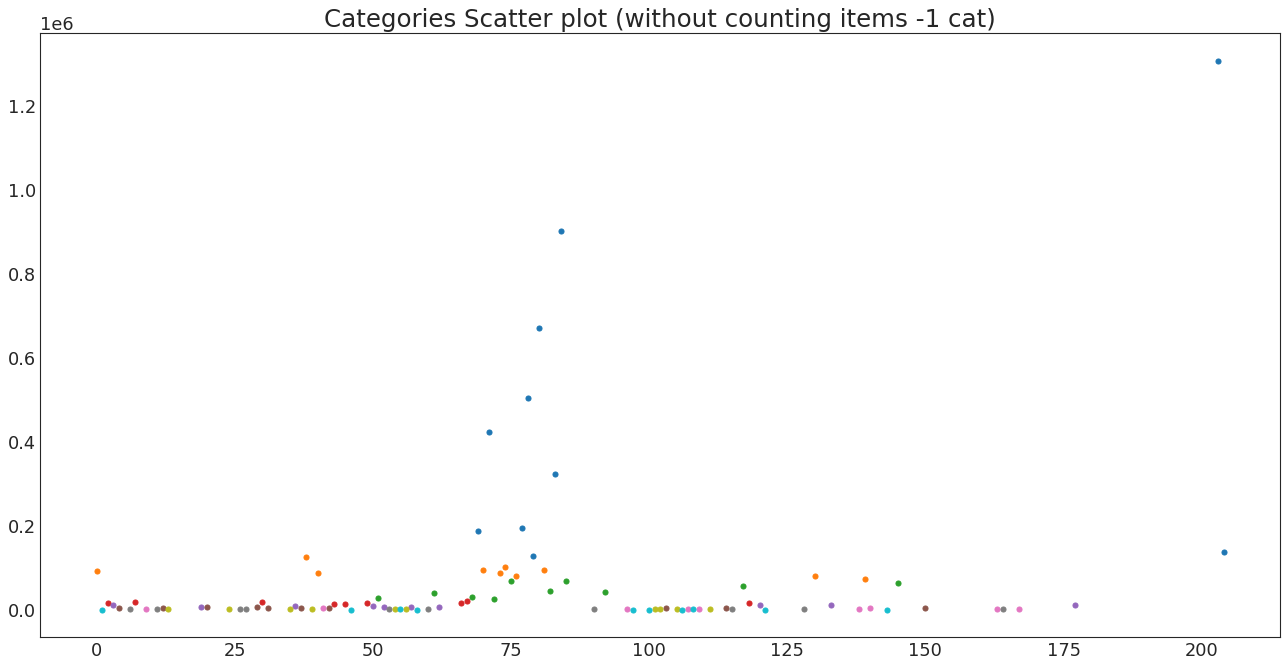

In [ ]:

# Prepare Data 
# Create as many colors as there are unique midwest['category']
categories = categories_count[categories_count['cat'] != -1]['cat']
colors = [plt.cm.tab10(i/float(len(categories)-1)) for i in range(len(categories))]

# Draw Plot for Each Category
plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')

for i, category in enumerate(categories):
    plt.scatter('cat', 'count', 
                data=categories_count[categories_count['cat'] != -1].loc[categories_count.cat==category, :],
                s=20, c=colors[i], label=str(category))

# Decorations
#plt.gca().set(xlim=(0.0, 205), ylim=(0, 900000))

#plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Categories Scatter plot (without counting items -1 cat)", fontsize=22)
#plt.legend(fontsize=12)    
plt.show() 

In [ ]:
cats_brands_freq_df = pd.DataFrame(df[['brands', 'category_id']].dropna().value_counts().reset_index())
cats_brands_freq_df.columns = ['brands', 'category_id', 'item_count']

In [ ]:
#cats_brands_freq_df.groupby('category_id').count()

In [ ]:
%reload_ext google.colab.data_table
from google.colab import data_table
data_table.DataTable(cats_brands_freq_df.query('category_id != -1'), include_index=False, num_rows_per_page=10)

,brands,category_id,item_count
4,кока-кола,83,53406
14,орбит,84,26090
59,пепси,83,13449
84,пепси-кола,83,10945
112,вискас,145,9168
...,...,...,...
21096,русь,73,1
21101,пранафарм,38,1
21128,provoc,30,1
21132,kiabi,55,1


In [ ]:
# топ 5 самых частых категорий
categories_count.head(20)

,cat,count
0,-1,19610851
1,203,1307260
2,84,902507
3,80,670833
4,78,503199
5,71,422085
6,83,322656
7,77,193369
8,69,186312
9,204,136271


In [ ]:
#топ 5 самых редких категорий
categories_count.tail(20)

,cat,count
79,24,1149
80,13,801
81,105,741
82,56,690
83,101,626
84,111,612
85,39,507
86,35,480
87,102,459
88,54,456


In [ ]:
df[df['category_id'] == -1].shape[0] - df[df['category_id'] == -1]['brands'].isnull().sum()

6156543

In [ ]:
df.query("category_id == -1")['brands'].value_counts().head(100)

орбит              71904
кока-кола          69911
чудо               68404
aro                62998
пепси              46952
вискас             39457
фрутоняня          30177
приправыч          29052
провансаль         28183
святой источник    28148
дарницкий          27685
мираторг           26986
доширак            26644
слобода            24778
феликс             22326
лейс               21563
fine life          21557
от мартина         21370
лейз               20981
стм                20700
хайнц              20526
пепси-кола         20245
фруто няня         19938
бородинский        19538
махеевъ            19068
хохланд            18733
аленка             18672
сады придонья      18253
вкуснотеево        18237
даниссимо          18141
активиа            17911
one                17583
мистраль           17518
lays               17452
дирол              17383
мастер             17268
увелка             17033
нескафе            17002
rothmans           16981
хрустим            16763


# Чистка данных

In [ ]:
df[df['category_id'] == '-1']

,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands
0,7,5,09:50,Флуконазол капс 150мг №1 Вертекс,1.000,7,-1,-1,вертекс
2,39,4,11:28,"Борщ Станичный с тушенкой, 103 ккал (завод, з/у)",1.000,6,1,-1,None
6,39,4,11:28,"Филе Горизонт (филе птицы), 218 ккал",1.000,7,1,-1,горизонт
10,49,3,14:27,3 Бумага Упак 1/Прочи/В асс,1.000,8,1,-1,None
11,49,3,14:27,4 Бумага Упак 1/Прочи/В асс,1.000,8,1,-1,None
...,...,...,...,...,...,...,...,...,...
45729304,10016159,4,12:39,"Карам.""Ломтик""апел/лимон/грейфр. 1кг Яшкино",0.283,10,-1,-1,None
45729310,10016159,4,12:39,СМЕТАНА 20% Залесский Фермер 200 г. пл.ст.,1.000,7,6,-1,залесский фермер
45729312,10016159,4,12:39,Слива Черная Пантера 1кг,0.439,11,-1,-1,None
45729314,10016159,4,12:39,"Хлеб ""Заварной"" ржано-пшен. 0,4г нарезка Берез.",1.000,8,-1,-1,None


In [ ]:
items_without_cat_count = df.shape[0] - df[df['category_id'] != -1].shape[0]
print(f'Общее число чеков: {df.shape[0]}')
print(f'Число чеков без категории: {items_without_cat_count}')
print(f'Число размечанных чеков: {df.shape[0] - items_without_cat_count}')

Общее число чеков: 26094077
Число чеков без категории: 19610851
Число размечанных чеков: 6483226


In [ ]:
df[~df['brands'].isnull()]

(6801308, 9)